# Import Libraries

In [26]:
import pandas as pd
import numpy as np
import missingno as mn

# Load Data

In [27]:
breed_stats = pd.read_csv('./datasets/working_data/breeds_info.csv')

In [28]:
breed_stats.head(3)

,breed,classification,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs
0,border collie,brightest dogs,0.95,1.0,4.0,19.000000,21.000000,40.000000,40.000000
1,poodle,brightest dogs,0.95,1.0,4.0,17.941176,20.908497,42.934641,57.522876
2,german shepherd,brightest dogs,0.95,1.0,4.0,22.000000,26.000000,75.000000,90.000000


List of all breeds

In [29]:
breeds = set(breed_stats['breed'])

In [30]:
shelter = pd.read_csv('./datasets/working_data/austin_clean_breed.csv')

In [31]:
shelter.head(3)

,id,name,date_in,location,intake_type,condition,age_in,breed,color,date_out,...,age_out,sex,intact_in,intact_out,age,primary_color,secondary_color,breed_1,breed_2,pure
0,A047759,Oreo,2014-04-02 15:55:00,Austin (TX),surrender,normal,10.0,dachshund,Tricolor,2014-04-07 15:12:00,...,10.0,1,0,0,Senior,tricolor,tricolor,dachshund,dachshund,1.0
1,A134067,Bandit,2013-11-16 09:02:00,12034 Research Blvd in Austin (TX),public_assist,injured,16.0,shetland sheepdog,Brown/White,2013-11-16 11:54:00,...,16.0,1,0,0,Senior,brown,white,shetland sheepdog,shetland sheepdog,1.0
2,A141142,Bettie,2013-11-16 14:46:00,Austin (TX),stray,aged,15.0,labrador retriever/pit bull,Black/White,2013-11-17 11:40:00,...,15.0,0,0,0,Senior,black,white,labrador retriever,pit bull,NaN


Check missing values

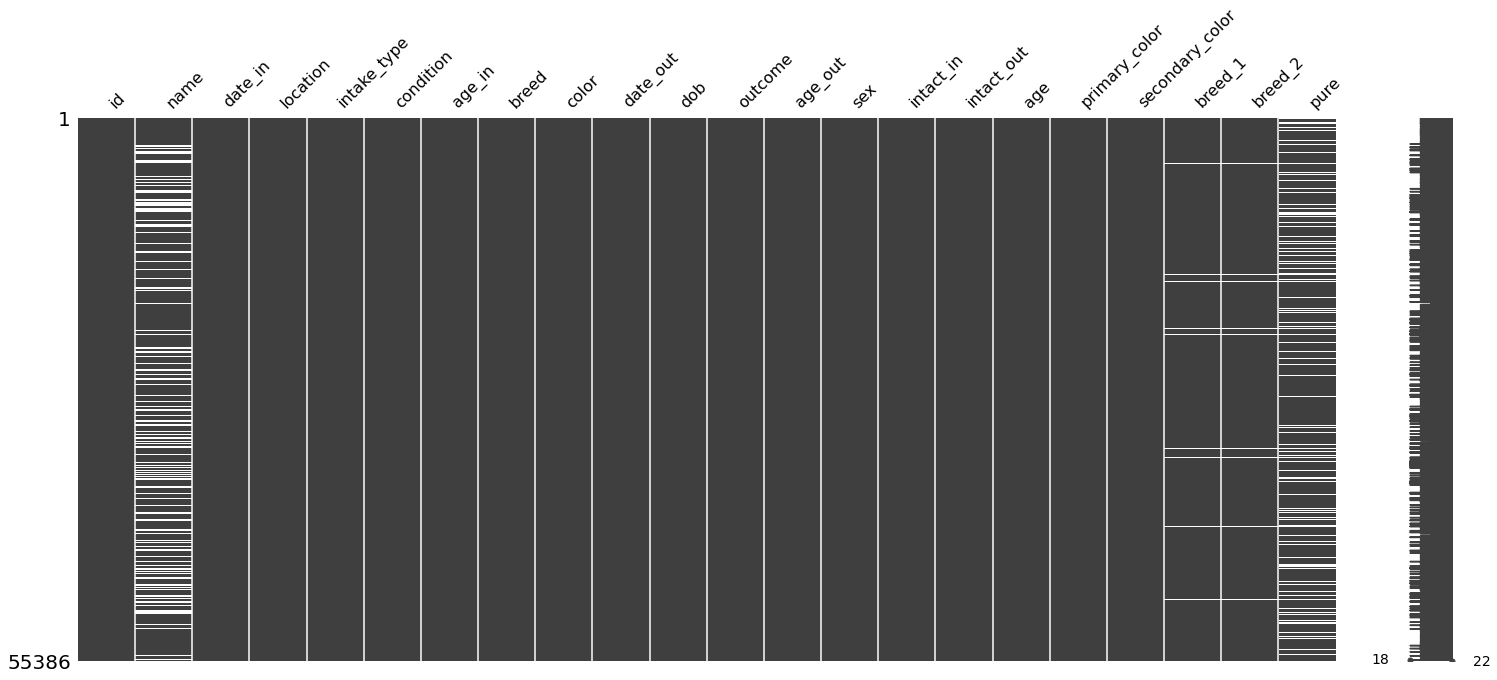

In [32]:
mn.matrix(shelter);

Lots of names missing, but names probably wont affect the model.

In [33]:
shelter['name'].fillna('unknown', inplace=True)
shelter['pure'].fillna(0, inplace=True)

Check missing remaining values.

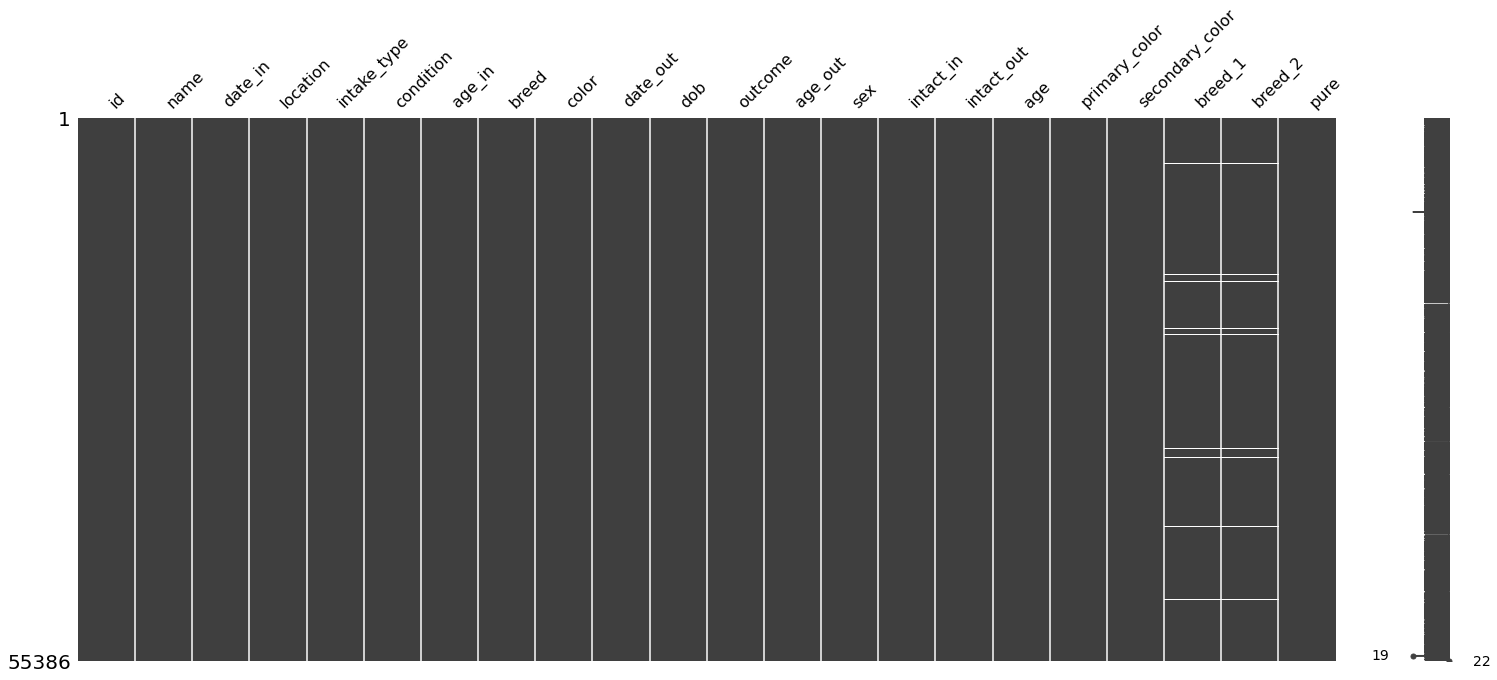

In [34]:
mn.matrix(shelter);

Drop missing values. Not missing too many.

In [38]:
shelter.isna().sum()[shelter.isna().sum() > 0]

intake_type       1
condition        11
breed_1        1869
breed_2        1869
dtype: int64

In [36]:
shelter.shape

(55386, 22)

In [39]:
shelter.dropna(inplace=True)

## Merge Breed Stats into Shelter Data

Average stats to fill unknown mixed breed characteristics

In [40]:
mix = []                                                                        # storage
for c in breed_stats.drop(columns=['breed', 'classification']).columns:
    mix.append(breed_stats[c].mean())                                           # get mean stat
mix = zip(breed_stats.drop(columns=['breed', 'classification']).columns, mix)   # convert to df
mix = pd.DataFrame(mix).T
mix.columns = mix.iloc[0]                                                       # rename cols
mix = mix[1:].copy()                                                            # drop row containing column names
mix = mix.add_suffix('_b2')                                                     # add col name suffix
mix                                                                             # inspect aggregate mix stats

,obey_b2,reps_lower_b2,reps_upper_b2,height_low_inches_b2,height_high_inches_b2,weight_low_lbs_b2,weight_high_lbs_b2
1,0.569858,25.319149,41.028369,17.941176,20.908497,42.934641,57.522876


In [41]:
def gen_breed_stats(x):
    
    d1 = breed_stats.drop(columns='classification').set_index('breed').loc[x['breed_1'],:]
    d1['breed_class'] = x['breed_1']
    
    if x['breed_2'] != 'mix':
        d2 = breed_stats.drop(columns='classification').set_index('breed').loc[x['breed_2'],:]
        d2['breed_class'] = x['breed_2']
    else:
        d2 = mix.squeeze()

    d1 = d1.add_suffix('_b1')   # data frame of breed_1
    d2 = d2.add_suffix('_b2')   # data frame of breed_2

    out = pd.concat([d1, d2])   # this line not working

    return out

In [42]:
# Lots of for loops... Can take a little while to run.
compile = shelter.apply(gen_breed_stats, axis=1)

In [43]:
compile.head(3)

,breed_class_b1,breed_class_b2,height_high_inches_b1,height_high_inches_b2,height_high_inches_b2_b2,height_low_inches_b1,height_low_inches_b2,height_low_inches_b2_b2,obey_b1,obey_b2,...,reps_lower_b2_b2,reps_upper_b1,reps_upper_b2,reps_upper_b2_b2,weight_high_lbs_b1,weight_high_lbs_b2,weight_high_lbs_b2_b2,weight_low_lbs_b1,weight_low_lbs_b2,weight_low_lbs_b2_b2
0,dachshund,dachshund,10.000000,10.000000,NaN,7.000000,7.000000,NaN,0.50,0.50,...,NaN,40.0,40.0,NaN,32.000000,32.000000,NaN,16.000000,16.000000,NaN
1,shetland sheepdog,shetland sheepdog,20.908497,20.908497,NaN,17.941176,17.941176,NaN,0.95,0.95,...,NaN,4.0,4.0,NaN,57.522876,57.522876,NaN,42.934641,42.934641,NaN
2,labrador retriever,pit bull,24.000000,19.000000,NaN,21.000000,17.000000,NaN,0.95,0.70,...,NaN,4.0,25.0,NaN,80.000000,50.000000,NaN,55.000000,40.000000,NaN


Average the stats of the two breeds. Will return original value for purebreed and an average value of the primary and secondary breed for mixed dogs.

In [45]:
# take average of breed 1 & breed 2 stats
def avg_breed_stats(df):
    # create empty dataframe
    new_df = pd.DataFrame()

    new_df['obey'] = (df['obey_b1'] + df['obey_b2']) / 2
    new_df['reps_lower'] = (df['reps_lower_b1'] + df['reps_lower_b2']) / 2
    new_df['reps_upper'] = (df['reps_upper_b1'] + df['reps_upper_b2']) / 2
    new_df['height_low_inches'] = (df['height_low_inches_b1'] + df['height_low_inches_b2']) / 2
    new_df['height_high_inches'] = (df['height_high_inches_b1'] + df['height_high_inches_b2']) / 2
    new_df['weight_low_lbs'] = (df['weight_low_lbs_b1'] + df['weight_low_lbs_b2']) / 2
    new_df['weight_high_lbs'] = (df['weight_high_lbs_b1'] + df['weight_high_lbs_b2']) / 2

    # returns averaged stats between the two breeds
    return new_df
    
all_stats = avg_breed_stats(compile)

In [46]:
all_stats.head(3)

,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs
0,0.500,26.0,40.0,7.000000,10.000000,16.000000,32.000000
1,0.950,1.0,4.0,17.941176,20.908497,42.934641,57.522876
2,0.825,8.5,14.5,19.000000,21.500000,47.500000,65.000000


710 observations with missing breed stats

In [48]:
all_stats.isna().sum()

obey                  710
reps_lower            710
reps_upper            710
height_low_inches     710
height_high_inches    710
weight_low_lbs        710
weight_high_lbs       710
dtype: int64

Merge shelter dataframe with their respective intelligence statistics.

In [49]:
shelter_with_stats = pd.concat([shelter, all_stats], axis=1)
shelter_with_stats.head(2)

,id,name,date_in,location,intake_type,condition,age_in,breed,color,date_out,...,breed_1,breed_2,pure,obey,reps_lower,reps_upper,height_low_inches,height_high_inches,weight_low_lbs,weight_high_lbs
0,A047759,Oreo,2014-04-02 15:55:00,Austin (TX),surrender,normal,10.0,dachshund,Tricolor,2014-04-07 15:12:00,...,dachshund,dachshund,1.0,0.50,26.0,40.0,7.000000,10.000000,16.000000,32.000000
1,A134067,Bandit,2013-11-16 09:02:00,12034 Research Blvd in Austin (TX),public_assist,injured,16.0,shetland sheepdog,Brown/White,2013-11-16 11:54:00,...,shetland sheepdog,shetland sheepdog,1.0,0.95,1.0,4.0,17.941176,20.908497,42.934641,57.522876


Convert dates to datetime

In [51]:
shelter_with_stats['date_in'] = pd.to_datetime(shelter_with_stats['date_in'])
shelter_with_stats['date_out'] = pd.to_datetime(shelter_with_stats['date_out'])

Calculate time spent in shelter.

In [52]:
shelter_with_stats['time_in_shelter'] = shelter_with_stats['date_out'] - shelter_with_stats['date_in']

Drop observations missing stats. Missing a very small percentage of total observations.

In [55]:
shelter_with_stats.shape

(53507, 30)

In [60]:
shelter_with_stats.isna().sum()[shelter_with_stats.isna().sum() > 0]

obey                  710
reps_lower            710
reps_upper            710
height_low_inches     710
height_high_inches    710
weight_low_lbs        710
weight_high_lbs       710
dtype: int64

In [61]:
shelter_with_stats.dropna(inplace=True)

<AxesSubplot:>

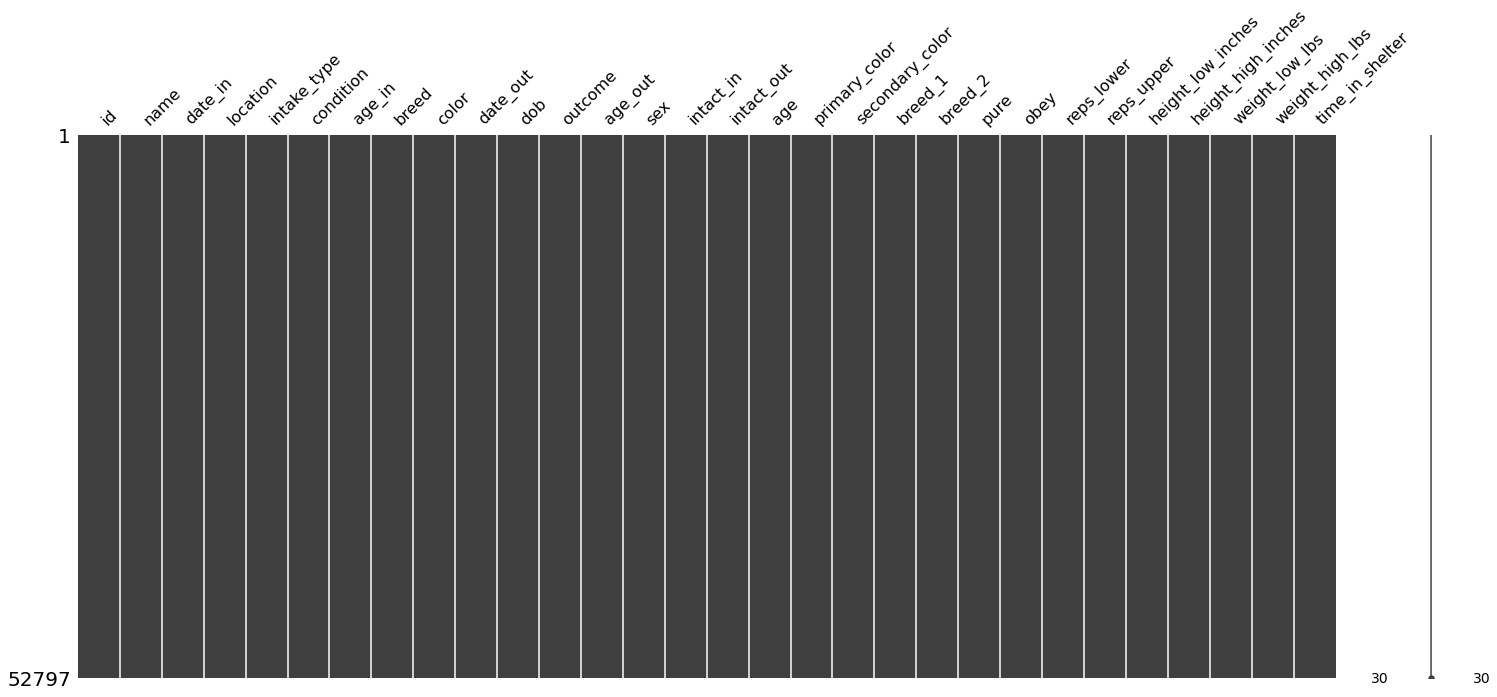

In [62]:
mn.matrix(shelter_with_stats);

# Export Data

In [63]:
shelter_with_stats.to_csv('./datasets/working_data/austin_clean_breed_stats.csv', index=False)

[Run Next](https://github.com/gwoodstock/gooddogs/blob/main/5_eda_1.ipynb): Exploratory Data Analysis.